In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.dpi'] = 200

data = pd.read_csv('OnlineNewsPopularity_ForModeling.csv',index_col='url')
data = data.drop(index=['http://mashable.com/2014/08/18/ukraine-civilian-convoy-attacked/','http://mashable.com/2013/12/09/wearably/'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39414 entries, http://mashable.com/2013/01/07/amazon-instant-video-browser/ to http://mashable.com/2014/08/15/rick-perry-indicted/
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   n_tokens_title                39414 non-null  float64
 1   n_tokens_content              39414 non-null  float64
 2   n_unique_tokens               39414 non-null  float64
 3   n_non_stop_words              39414 non-null  float64
 4   n_non_stop_unique_tokens      39414 non-null  float64
 5   num_hrefs                     39414 non-null  float64
 6   num_self_hrefs                39414 non-null  float64
 7   num_imgs                      39414 non-null  float64
 8   num_videos                    39414 non-null  float64
 9   average_token_length          39414 non-null  float64
 10  num_keywords                  39414 non-null  float64
 11  self_reference_min_

In [2]:
def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def Random_Forest_Model(model_data, y_var,best_depth=None,cm=True,roc=False):
    """
    Quickly makes a Random Forest Model, provides accuracy scores and provides confusion matrix 
    unless specified otherwise. Allow for the specification of depth.
    """
    # use the selected y_var to seperate the X and Y variables
    y_var_values = model_data[y_var].unique()
    X = model_data.drop(columns=y_var)
    y = model_data[y_var].replace(y_var_values,range(len(y_var_values)))
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,stratify=y)
    
    # make model
    scaler = StandardScaler()
    random_forest = RandomForestClassifier(max_depth=best_depth)
    pipe = make_pipeline(scaler,random_forest)
    
    # fit model and predict
    pipe.fit(X_train,y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    
    # print accuracy score
    print('training accuracy:',accuracy_score(y_train, y_pred_train))
    print('test accuracy:',accuracy_score(y_test, y_pred_test))
    
    # if cm == True, plot the confusion matrix
    if cm == True:
        cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
        cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
        
        plt.figure(figsize=(12,6),dpi=200)
        plt.subplot(121)
        plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')
        plt.subplot(122)
        plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')
        
    # if roc == True, plot the roc curve
    if roc == True:
        y_pred_train_proba = pipe.predict_proba(X_train)[:, 1]
        y_pred_test_proba = pipe.predict_proba(X_test)[:, 1]
        fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
        
        plt.figure(figsize=(12,6),dpi=200)
        plt.subplot(121)
        plt.title('Train ROC')
        plt.plot(fpr_train, tpr_train)
        plt.subplot(122)
        plt.title('Test ROC')
        plt.plot(fpr_test, tpr_test)
    
    #returns the pipeline
    return pipe

# Random Forest Model
Start by making a model

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Three Brackets
For simplicity, I tried seperating the entries into three seperate brackets based on percentiles

training accuracy: 0.8643299865888578
test accuracy: 0.7617758985200845


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=15, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

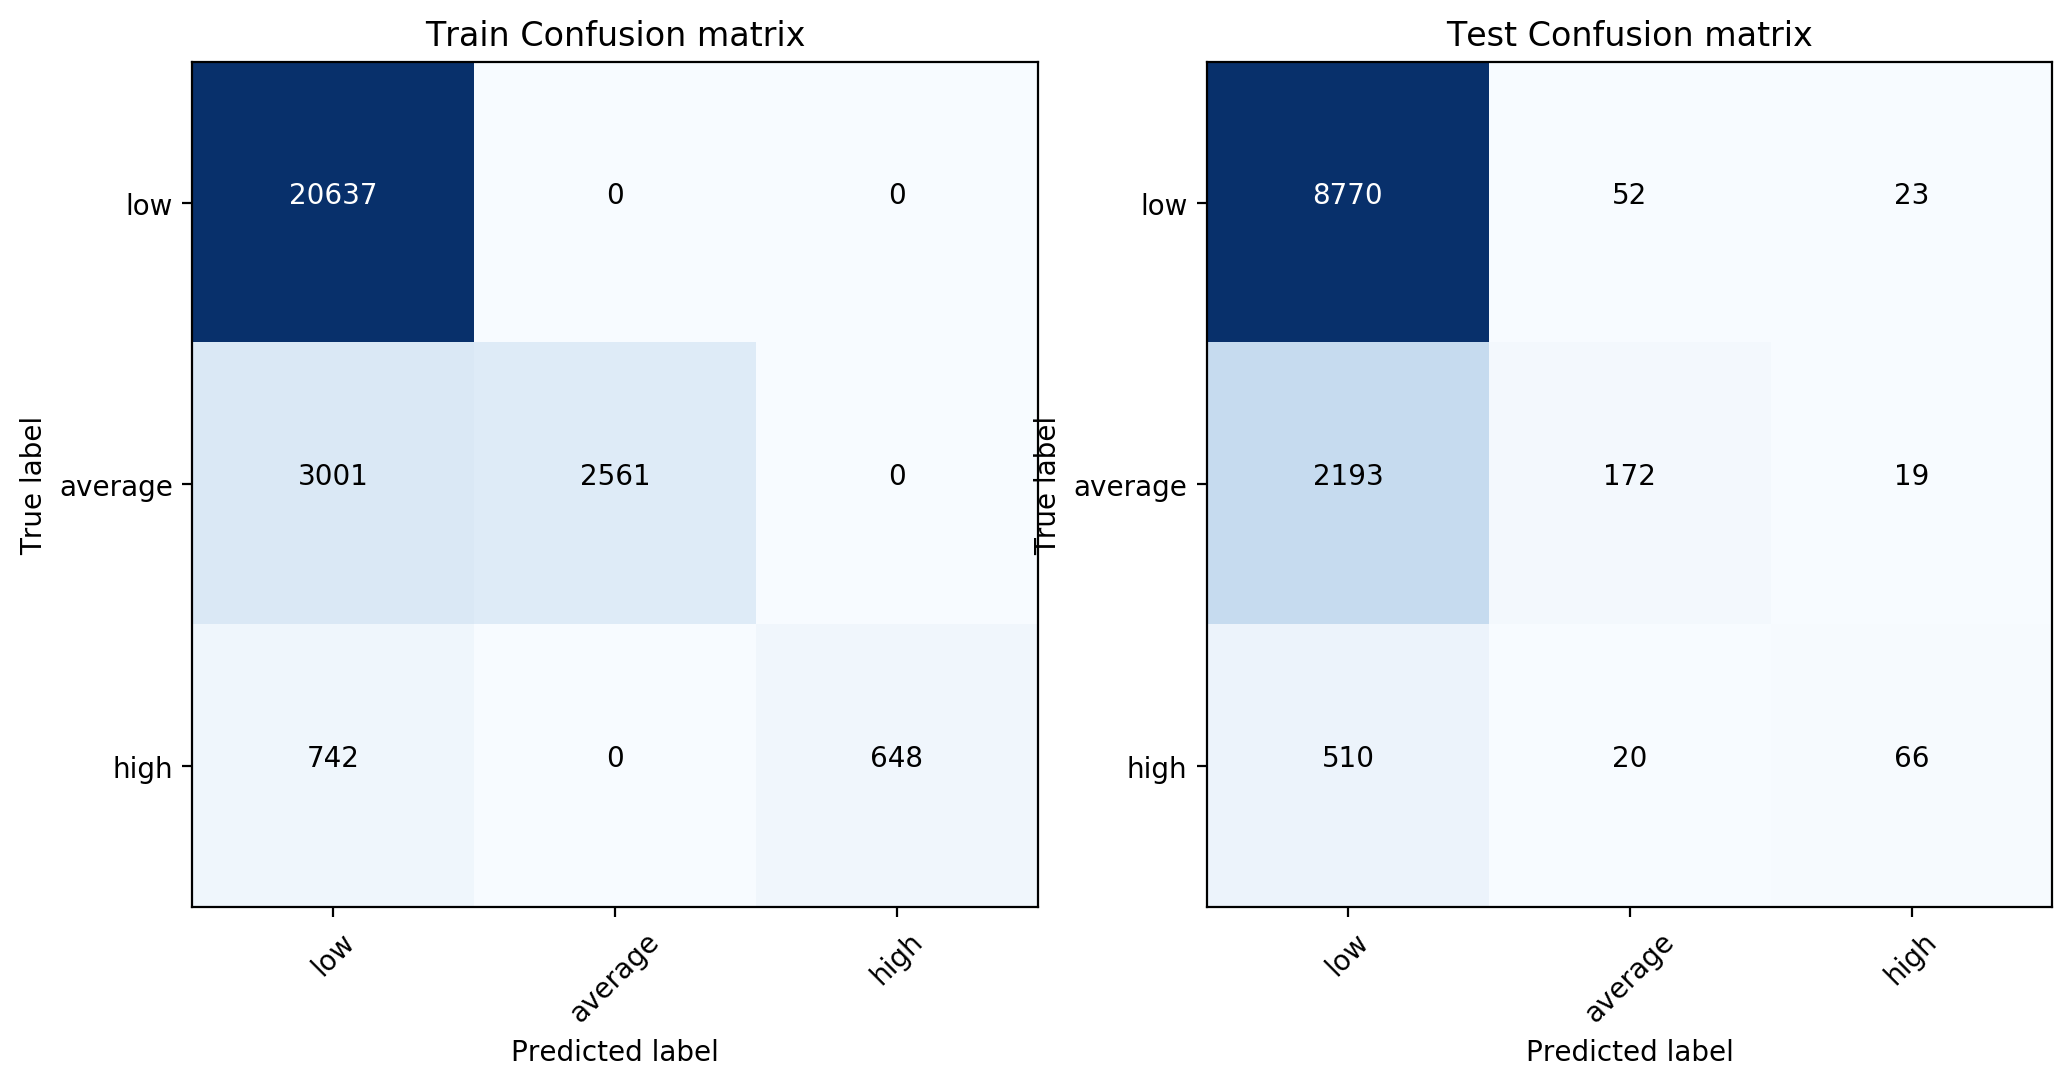

In [4]:
model_data_1 = data.copy()

avg = int(np.percentile(model_data_1.shares,[0,75])[1])
high = int(np.percentile(model_data_1.shares,[0,95])[1])

# Seperate entries into three categories
index = model_data_1[model_data_1.shares < avg].index
model_data_1.loc[index,'category'] = 'low'

index = model_data_1[(model_data_1.shares >= avg) & (model_data_1.shares < high)].index
model_data_1.loc[index,'category'] = 'average'

index = model_data_1[model_data_1.shares >= high].index
model_data_1.loc[index,'category'] = 'high'

# Appends together
model_data_1 = model_data_1.drop(columns='shares')

Random_Forest_Model(model_data_1,'category',best_depth=15)

Not a very good model its seem. Its misclassifing alot of entries as `low`, probably since there are too many entries in that catergory. So I'll try limiting the amount of entries so that there is an equal amount of all of them

training accuracy: 0.9961630695443645
test accuracy: 0.6017897091722595


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=13, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

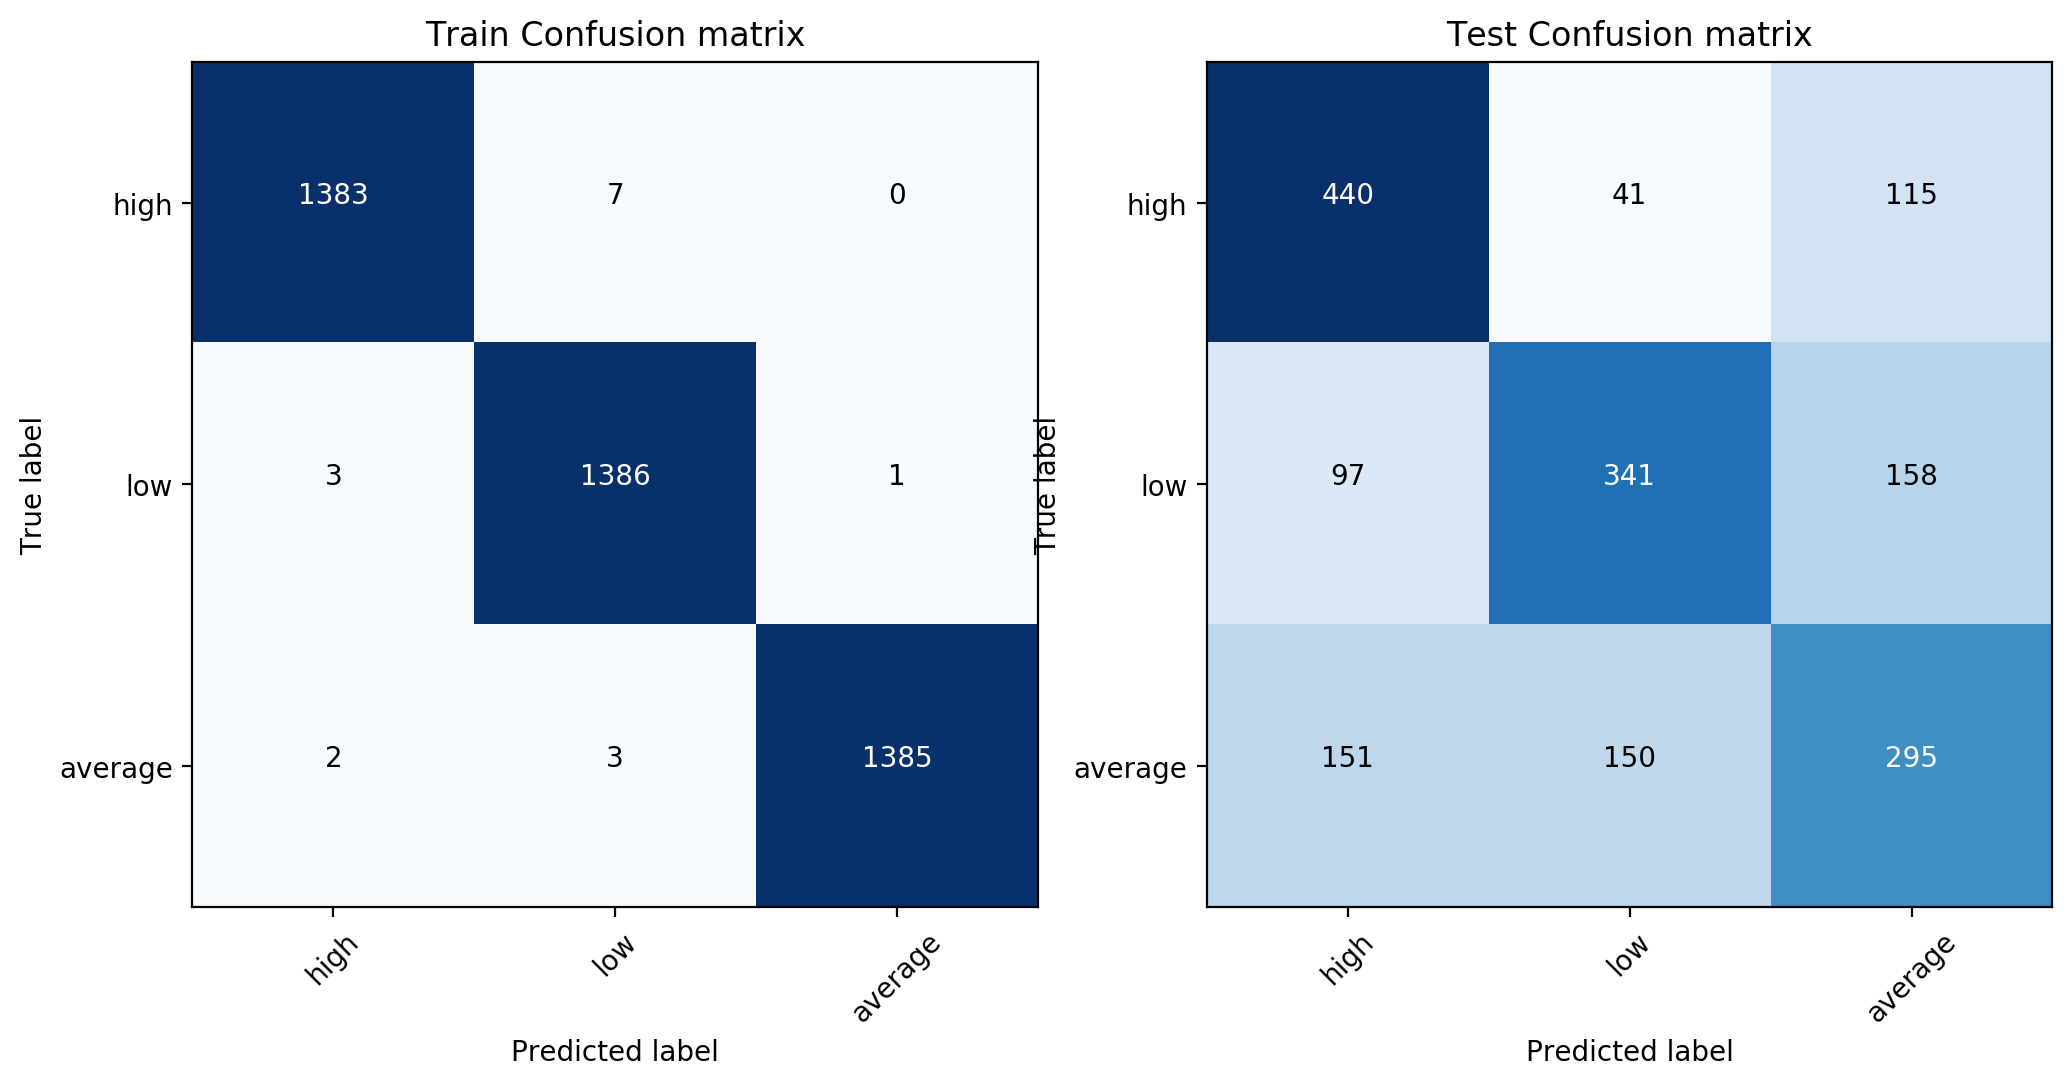

In [5]:
def lim_entries(data,column,both=False):
    '''
    Takes a dataframe and a selected column and equalizes the distribution.
    '''
    entries = list(data[column].value_counts().index[:-1])
    n = list(data[column].value_counts())[-1]
    new = data.loc[data[column] == data[column].value_counts().index[-1]]
    
    for entry in entries:
        selected = data[data[column] == entry].reset_index()
        selected_col = selected.columns
        index = selected_col[0]
        selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
        new = new.append(selected)  
    if both == True:
        new = [new,data.drop(index=list(new.index))]
    return new

model_data_1 = lim_entries(model_data_1,'category')
Random_Forest_Model(model_data_1,'category',best_depth=13)

Accuracy really increased, seems that the model can label high values quite well, but it does seem to mislabel some

# Popularity
Split entries into popular and unpopular

training accuracy: 1.0
test accuracy: 0.8523206751054853


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=11, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=Fal

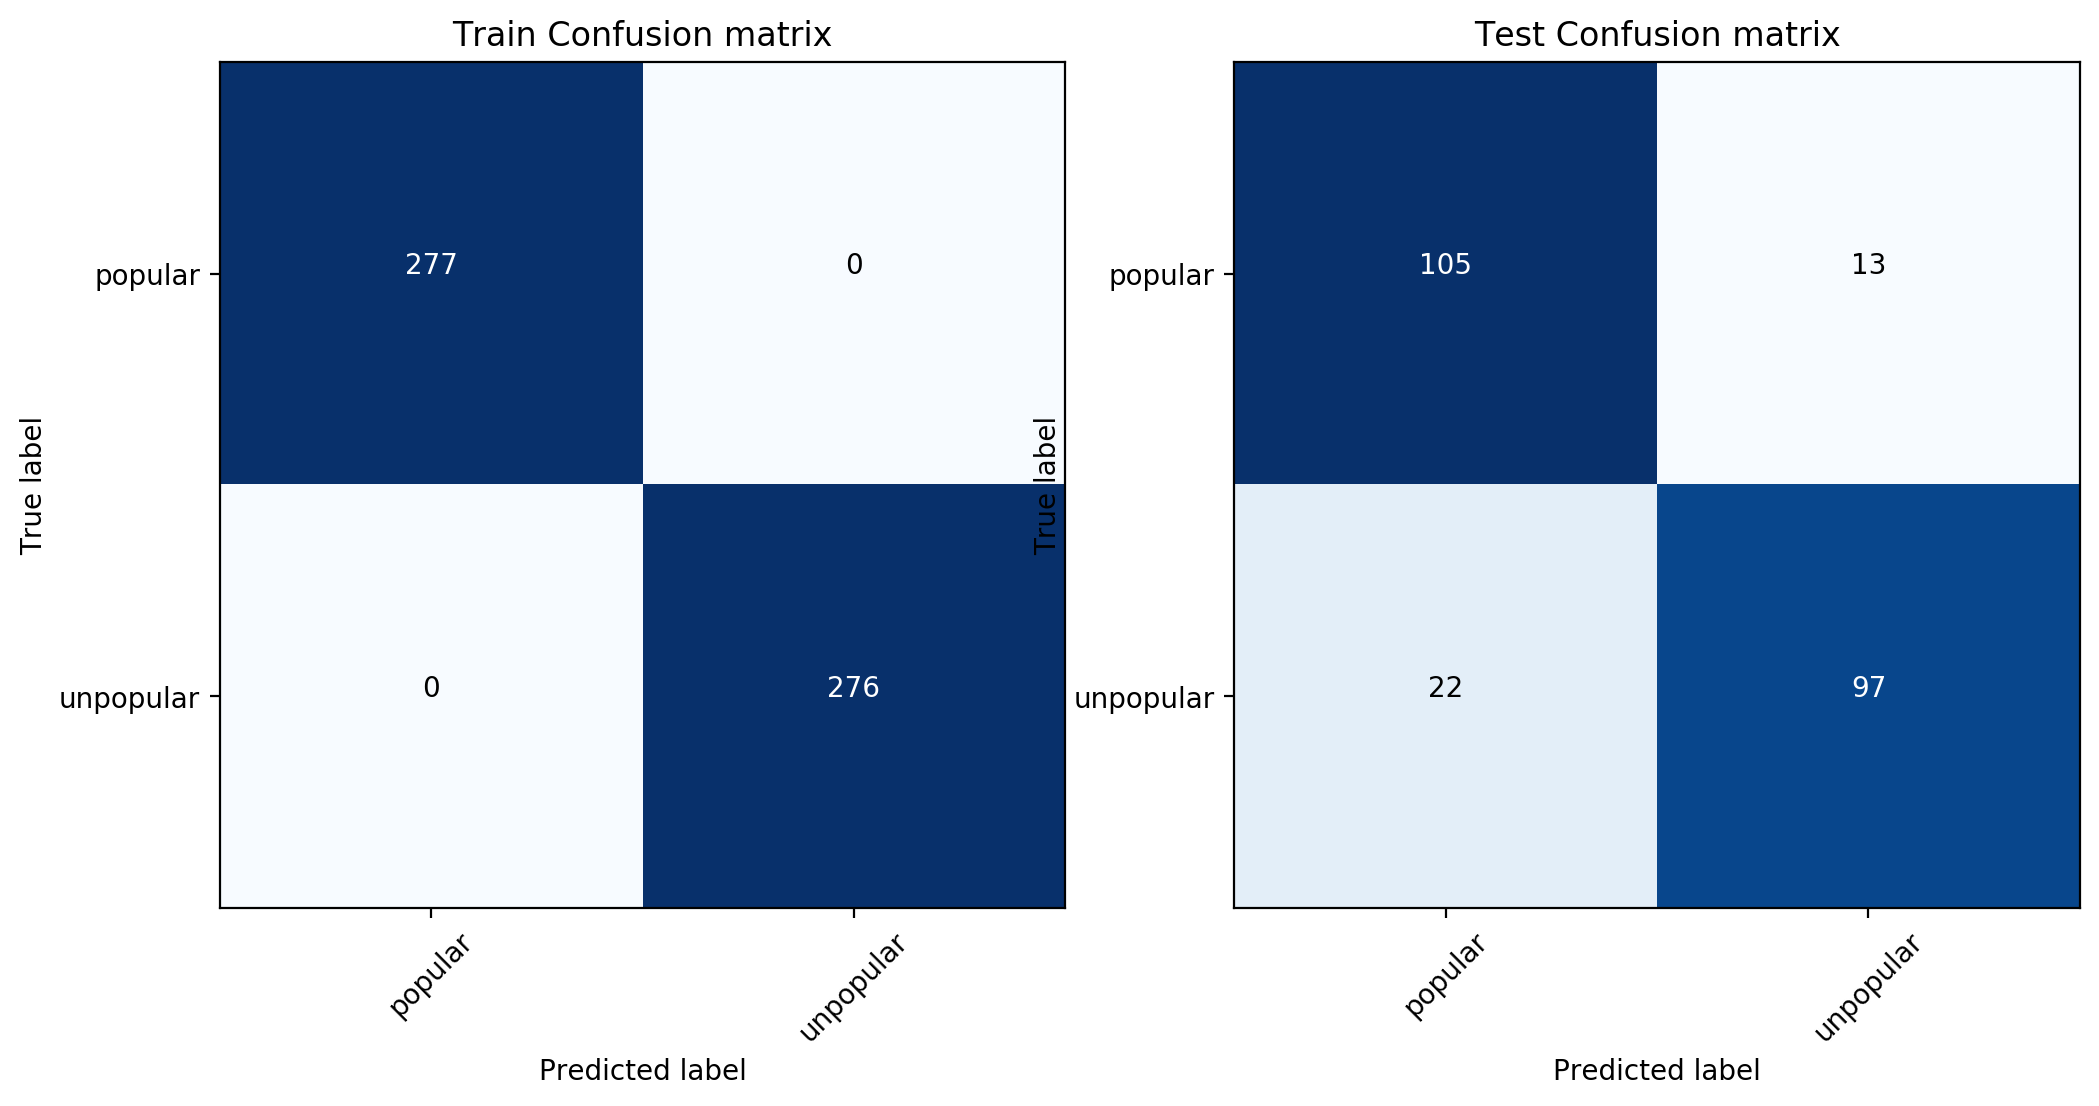

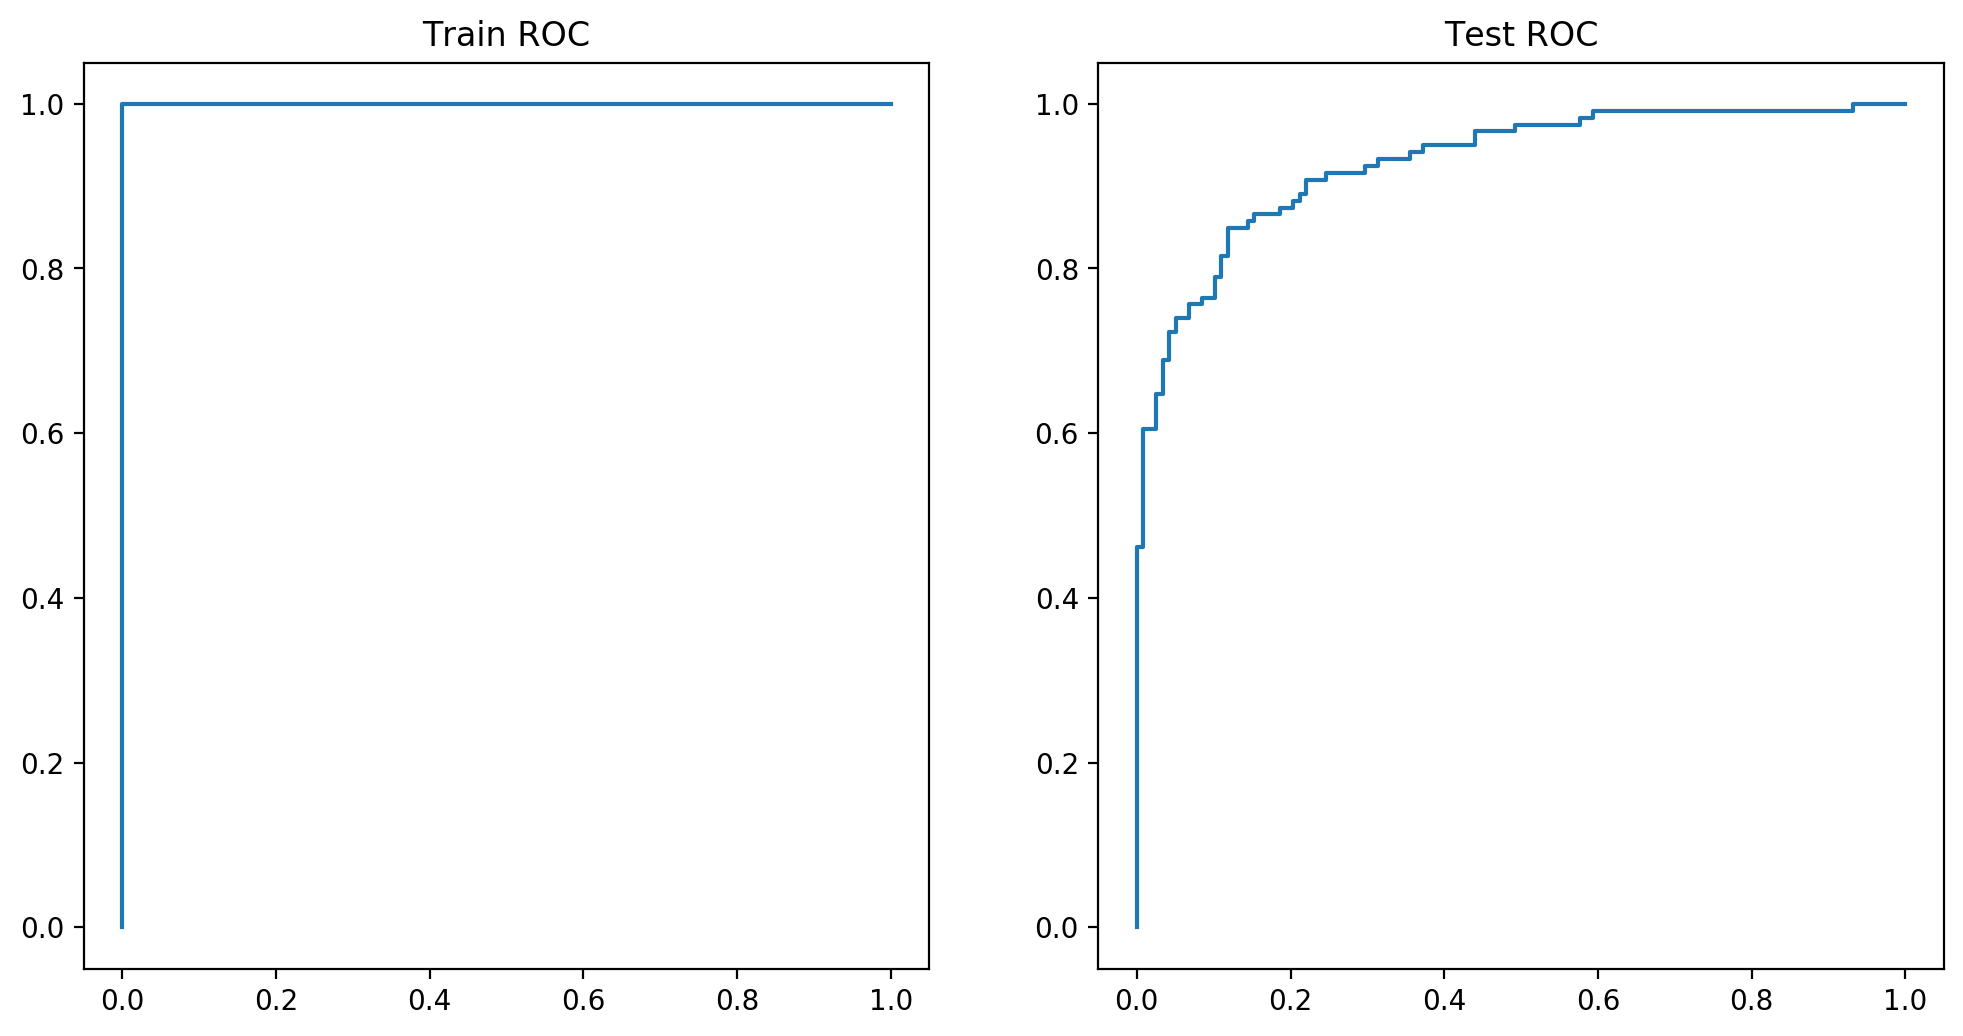

In [6]:
model_data_2 = data.copy()
pop = np.percentile(model_data_2.shares,[0,99])[1]

# Seperate entries into two categories
popular = model_data_2[(model_data_2.shares > pop)].index
model_data_2.loc[popular,'category'] = 'popular'

unpopular = model_data_2[model_data_2.shares <= pop].index
model_data_2.loc[unpopular,'category'] = 'unpopular'

model_data_2 = model_data_2.drop(columns='shares')

# Limit the amount of entries
model_data_2 = lim_entries(model_data_2,'category')

# Model
Random_Forest_Model(model_data_2,'category',best_depth=11,roc=True)

It seems this model works better, so for ease I'll make it a definition

In [7]:
def model_popularity(data):
    pop_thresh = np.percentile(data.shares,[0,90])[1]
    data.assign(category=np.nan)

    popular = data[(data.shares > pop_thresh)].index
    data.loc[popular,'category'] = 'popular'

    unpopular = data[data.shares <= pop_thresh].index
    data.loc[unpopular,'category'] = 'unpopular'

    data = data.drop(columns='shares')

    data = lim_entries(data,'category')
    
    return data

# K Means Clustering

In [8]:
from sklearn.cluster import KMeans

Start by finding the best amount of clusters for the model

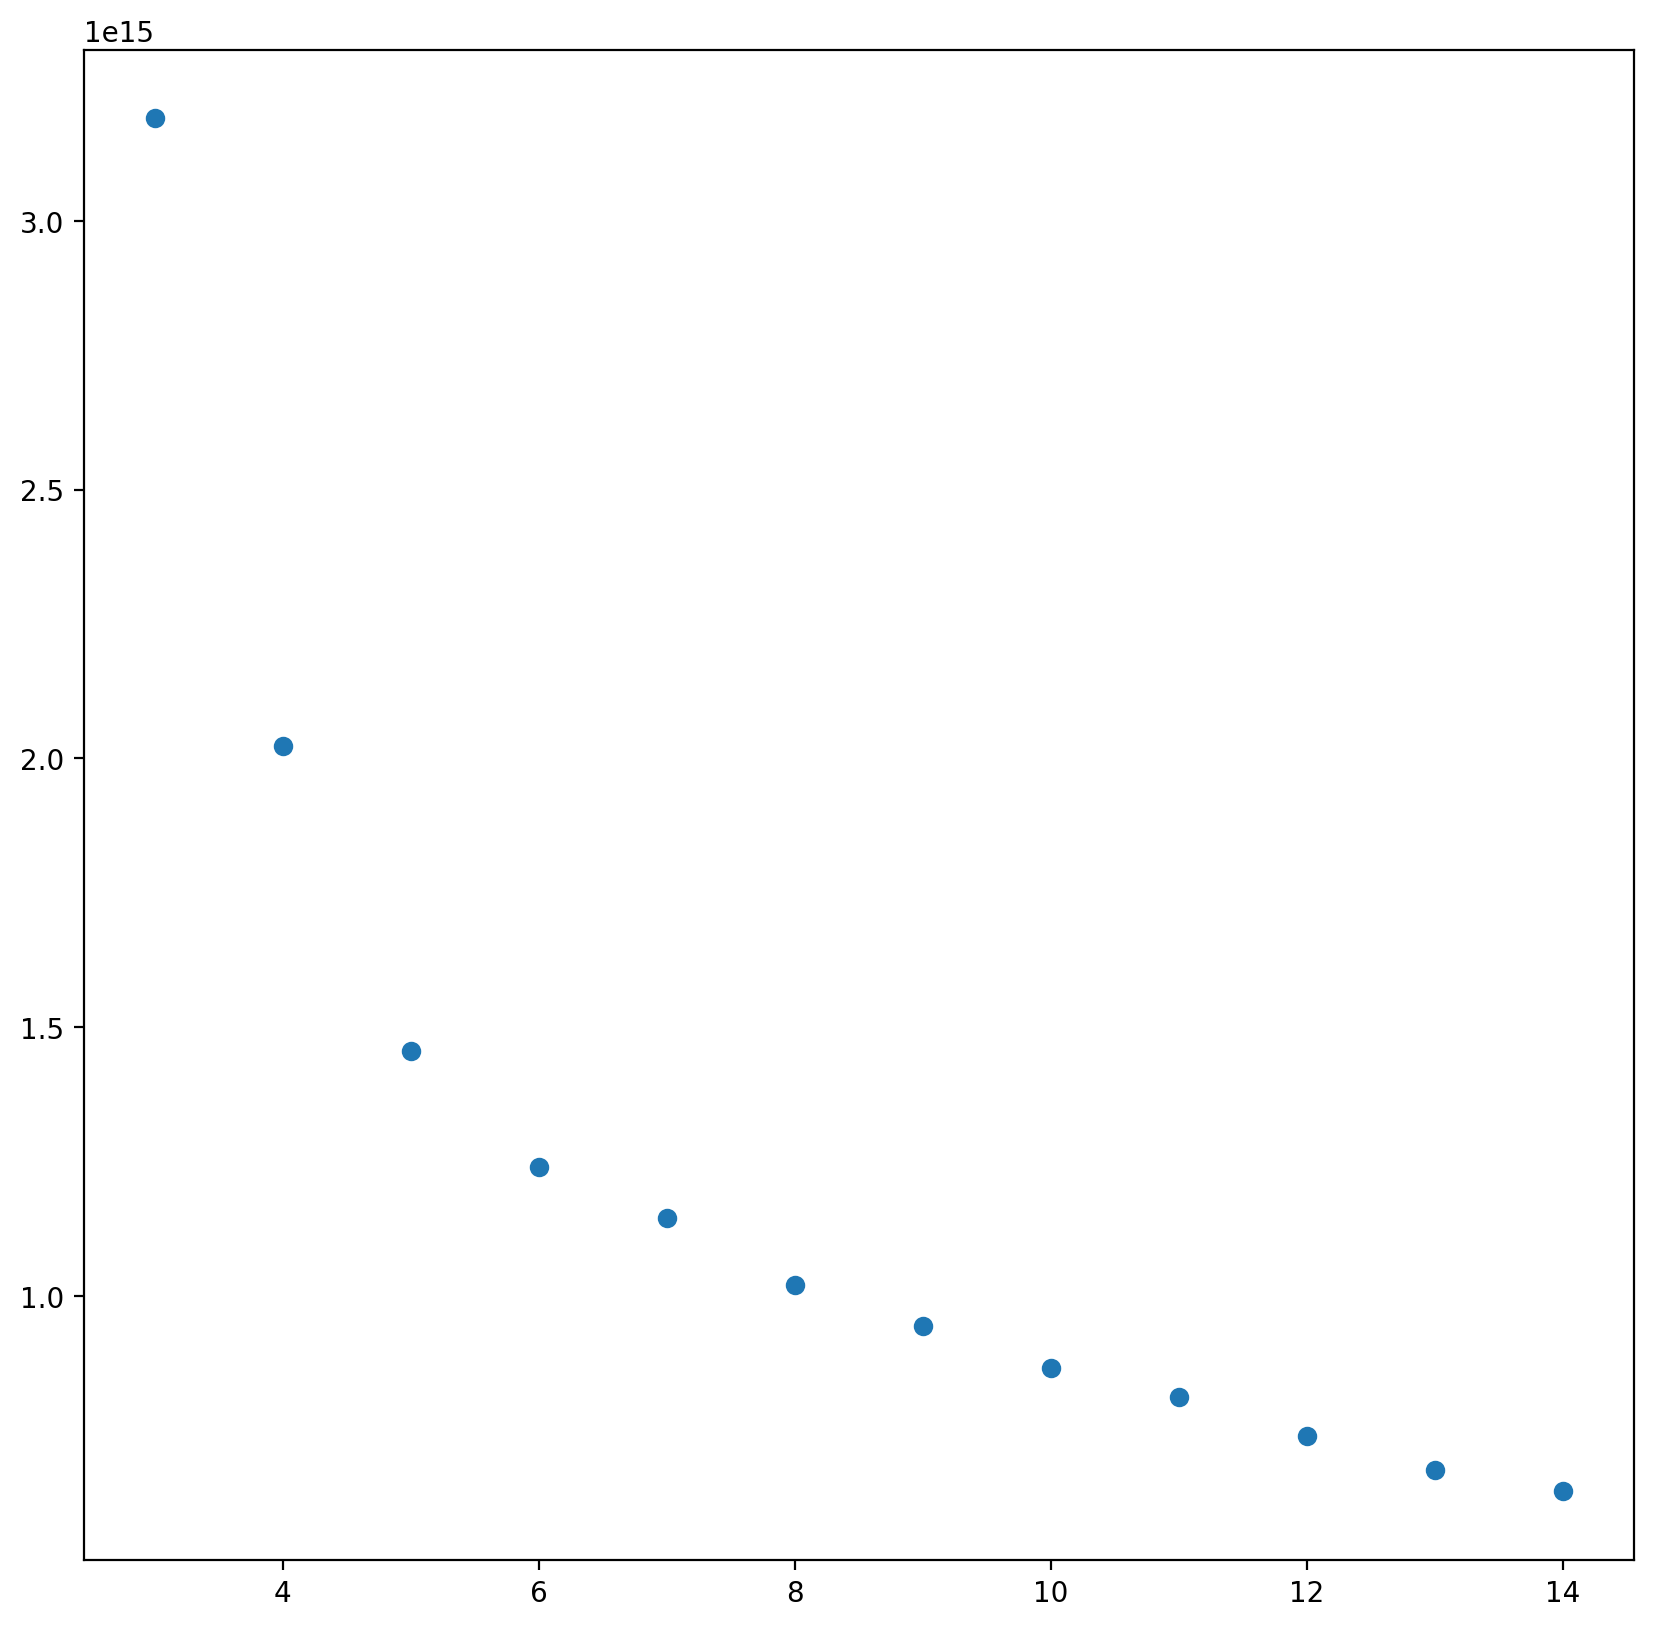

In [9]:
model_data_km = data.copy()

K_range = range(3,15)
inertia = []

for k in K_range:
    scaler = StandardScaler()
    scaler.fit(model_data_km)
    scaler.transform(model_data_km)
    model = KMeans(n_clusters=k)
    model.fit(model_data_km)
    inertia.append(model.inertia_)

plt.scatter(K_range,inertia)

Seven looks like a good 'elbow' point, so I'll use seven clusters

In [10]:
model_data_km = data.copy()

X_km = model_data_km
k = 6

scalar = StandardScaler()
model = KMeans(n_clusters=k)
pipe = make_pipeline(scalar, model)
pipe.fit(X_km)

label=pipe.predict(X_km)

model_data_km['label'] = label

model_data_km.label.value_counts()

4    12132
5    10920
0     9574
2     5487
3     1173
1      128
Name: label, dtype: int64

After runnning the model a couple times, the same two articles aways got their own cluster. It seems that despite having text, all the text related columns are 0, not to mentaion that self_reference_max_shares is less self_reference_min_shares. This must be an error so it will be removed from the data.

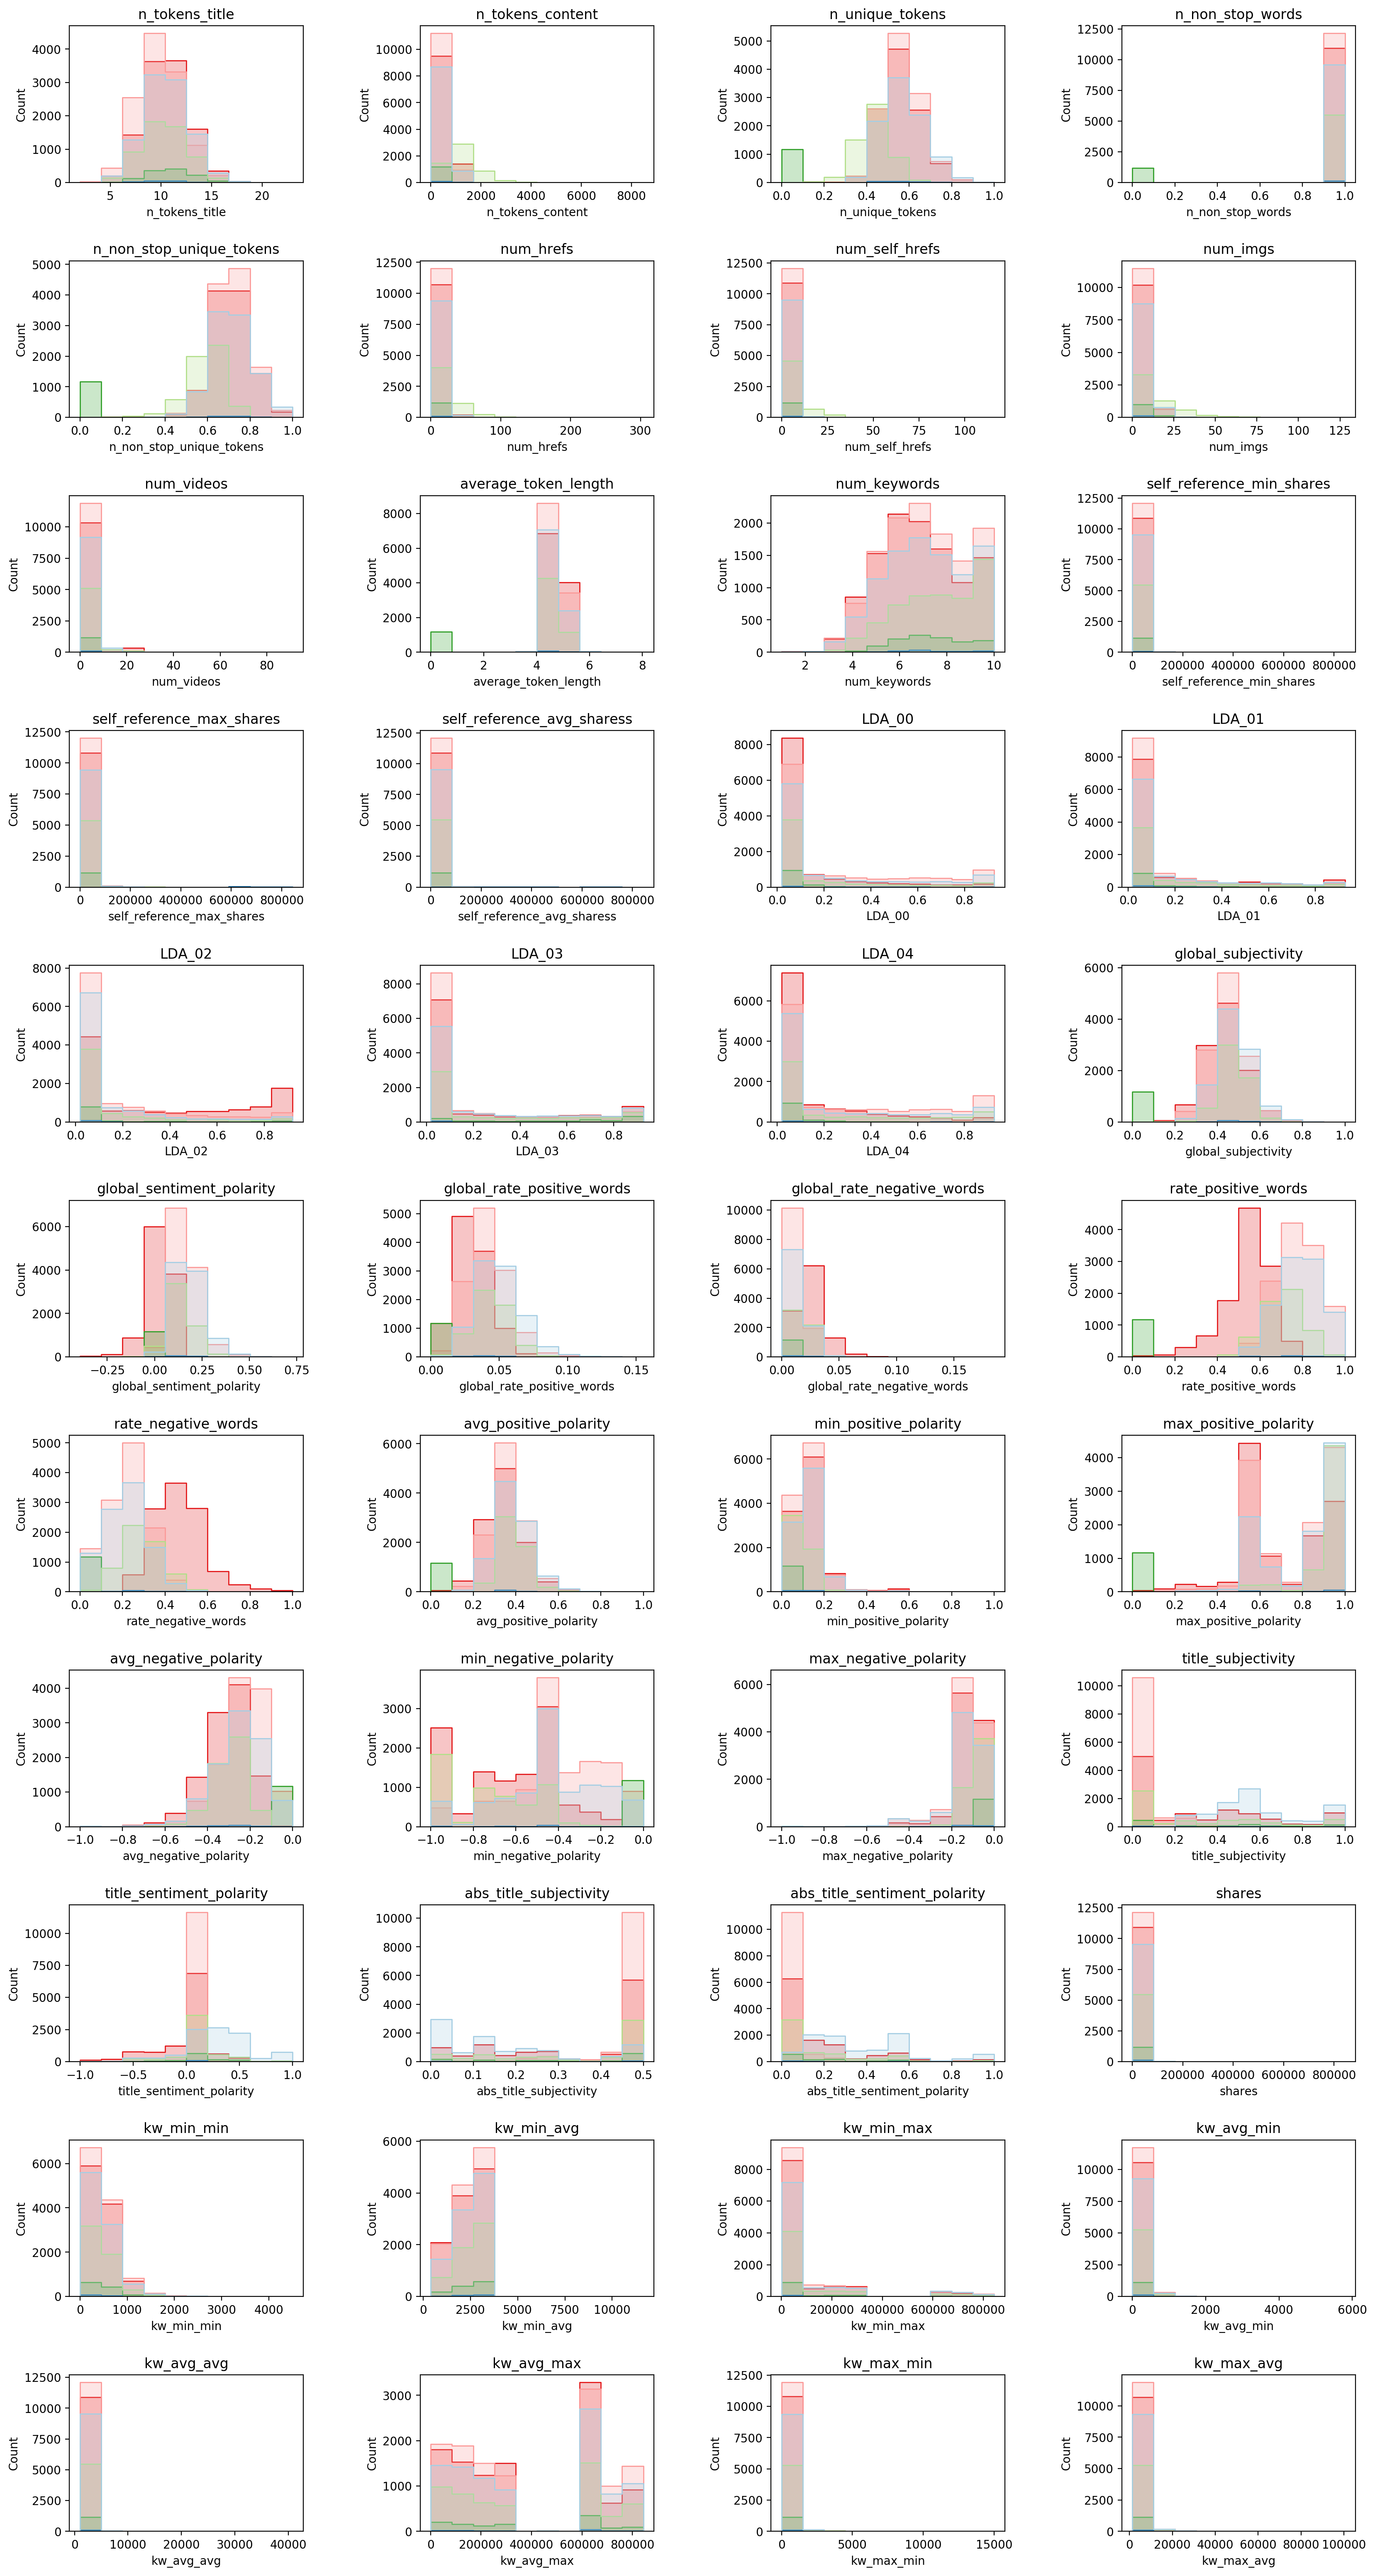

In [11]:
plt.figure(figsize=(20,40),dpi=200)
plt.subplots_adjust(hspace=0.5,wspace=0.5)
for n,col_name in enumerate(model_data_km.columns[0:44],start=1):
    plt.subplot(11,4,n)
    sns.histplot(data=model_data_km,x=col_name, hue="label",palette='Paired',bins=10,element='step',legend=False)
    plt.title(col_name)

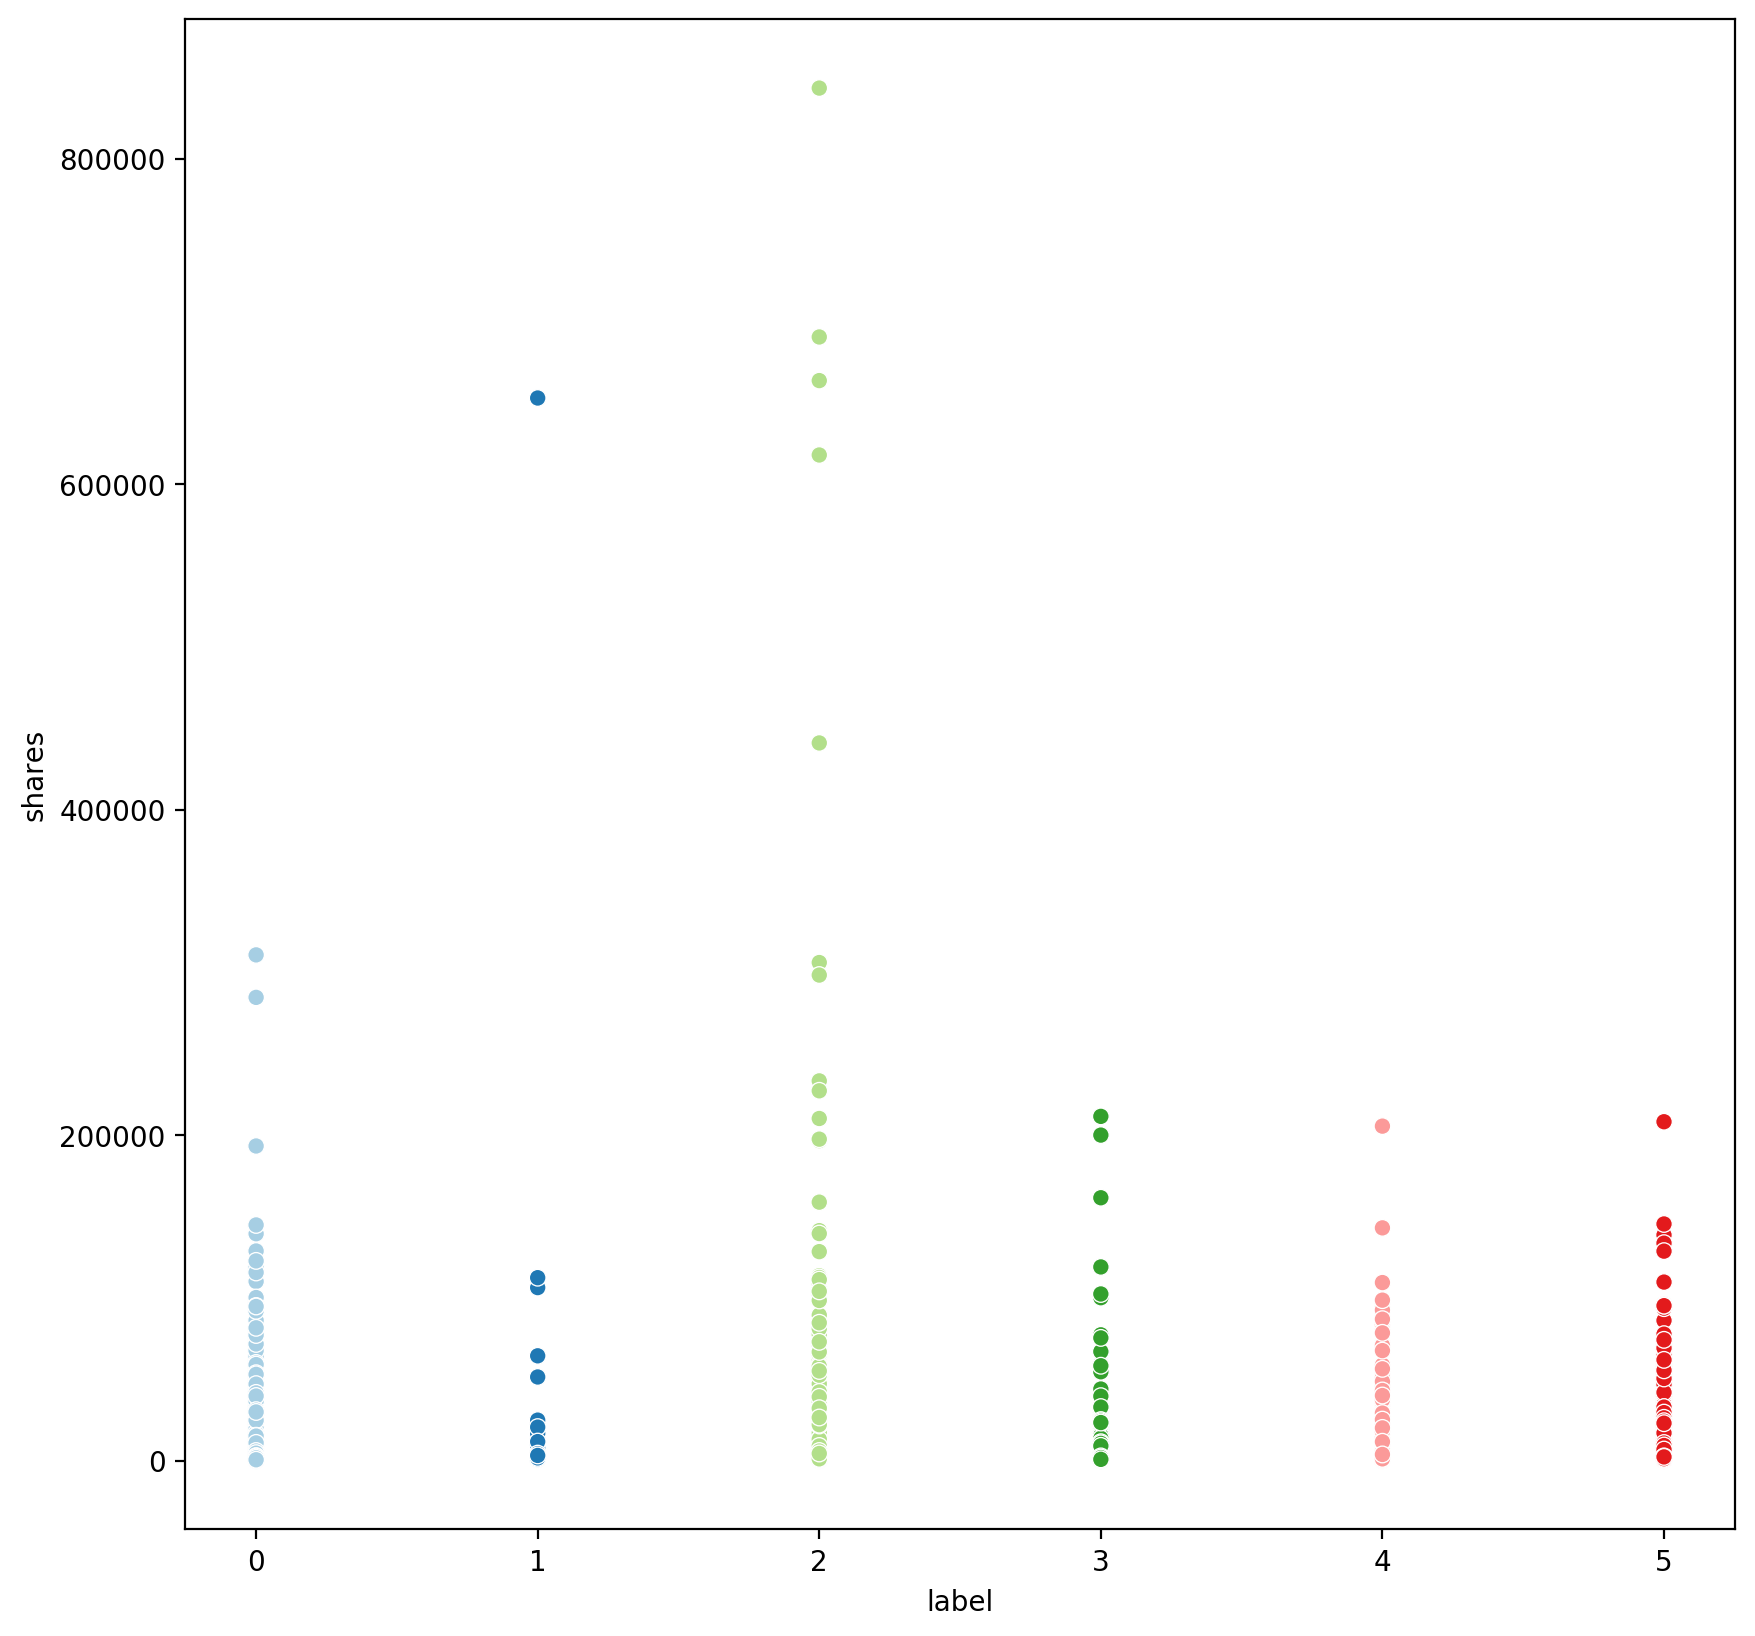

In [12]:
sns.scatterplot(data=model_data_km,x='label',y='shares',hue='label',palette='Paired',legend=False)

From what i can gather from these histograms...
 - Cluster 0 (cyan): articles that learn more towards a positive side
 - Cluster 2 (light green): articles that are less wordy and with more media (img/vid)
 - Cluster 3 (green): articles with no text
 - Cluster 5 (red): less subjective, more negative
 

# PCA

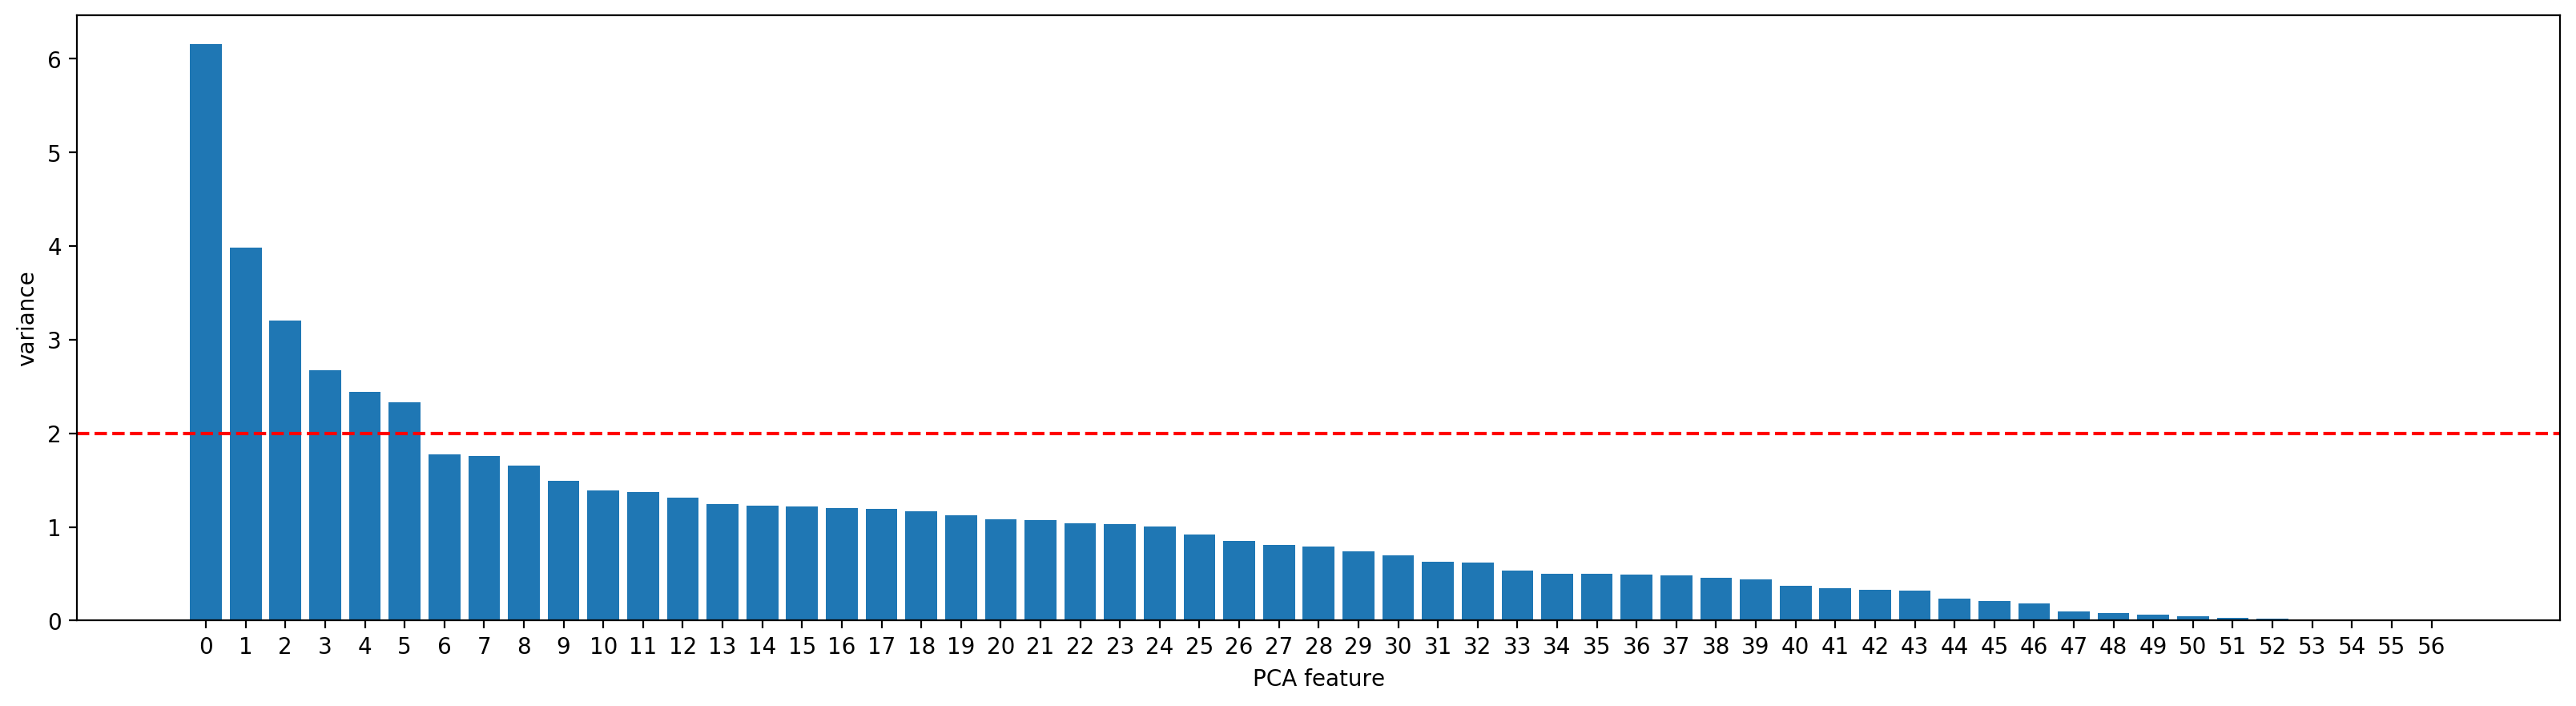

In [13]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

data_pca = model_data_km.copy()

X_pca = data_pca.drop(columns=['shares'])

# Create PCA instance: model
X_pca = StandardScaler().fit_transform(X_pca)
model = PCA().fit(X_pca)

# Apply the fit_transform method of model to grains: pca_features
pca_features = model.transform(X_pca)
features = pd.DataFrame({'features':range(0,model.n_components_),'varience':model.explained_variance_}).set_index('features')
pca_features = pd.DataFrame(pca_features)

# Set the variance threshold to select only top components
thresh = 2

# Plot the explained variances
plt.figure(figsize=(20,5))
plt.axhline(y=thresh,linestyle='--',c='r')
plt.bar(features.index,features.varience )
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features.index)
plt.show()

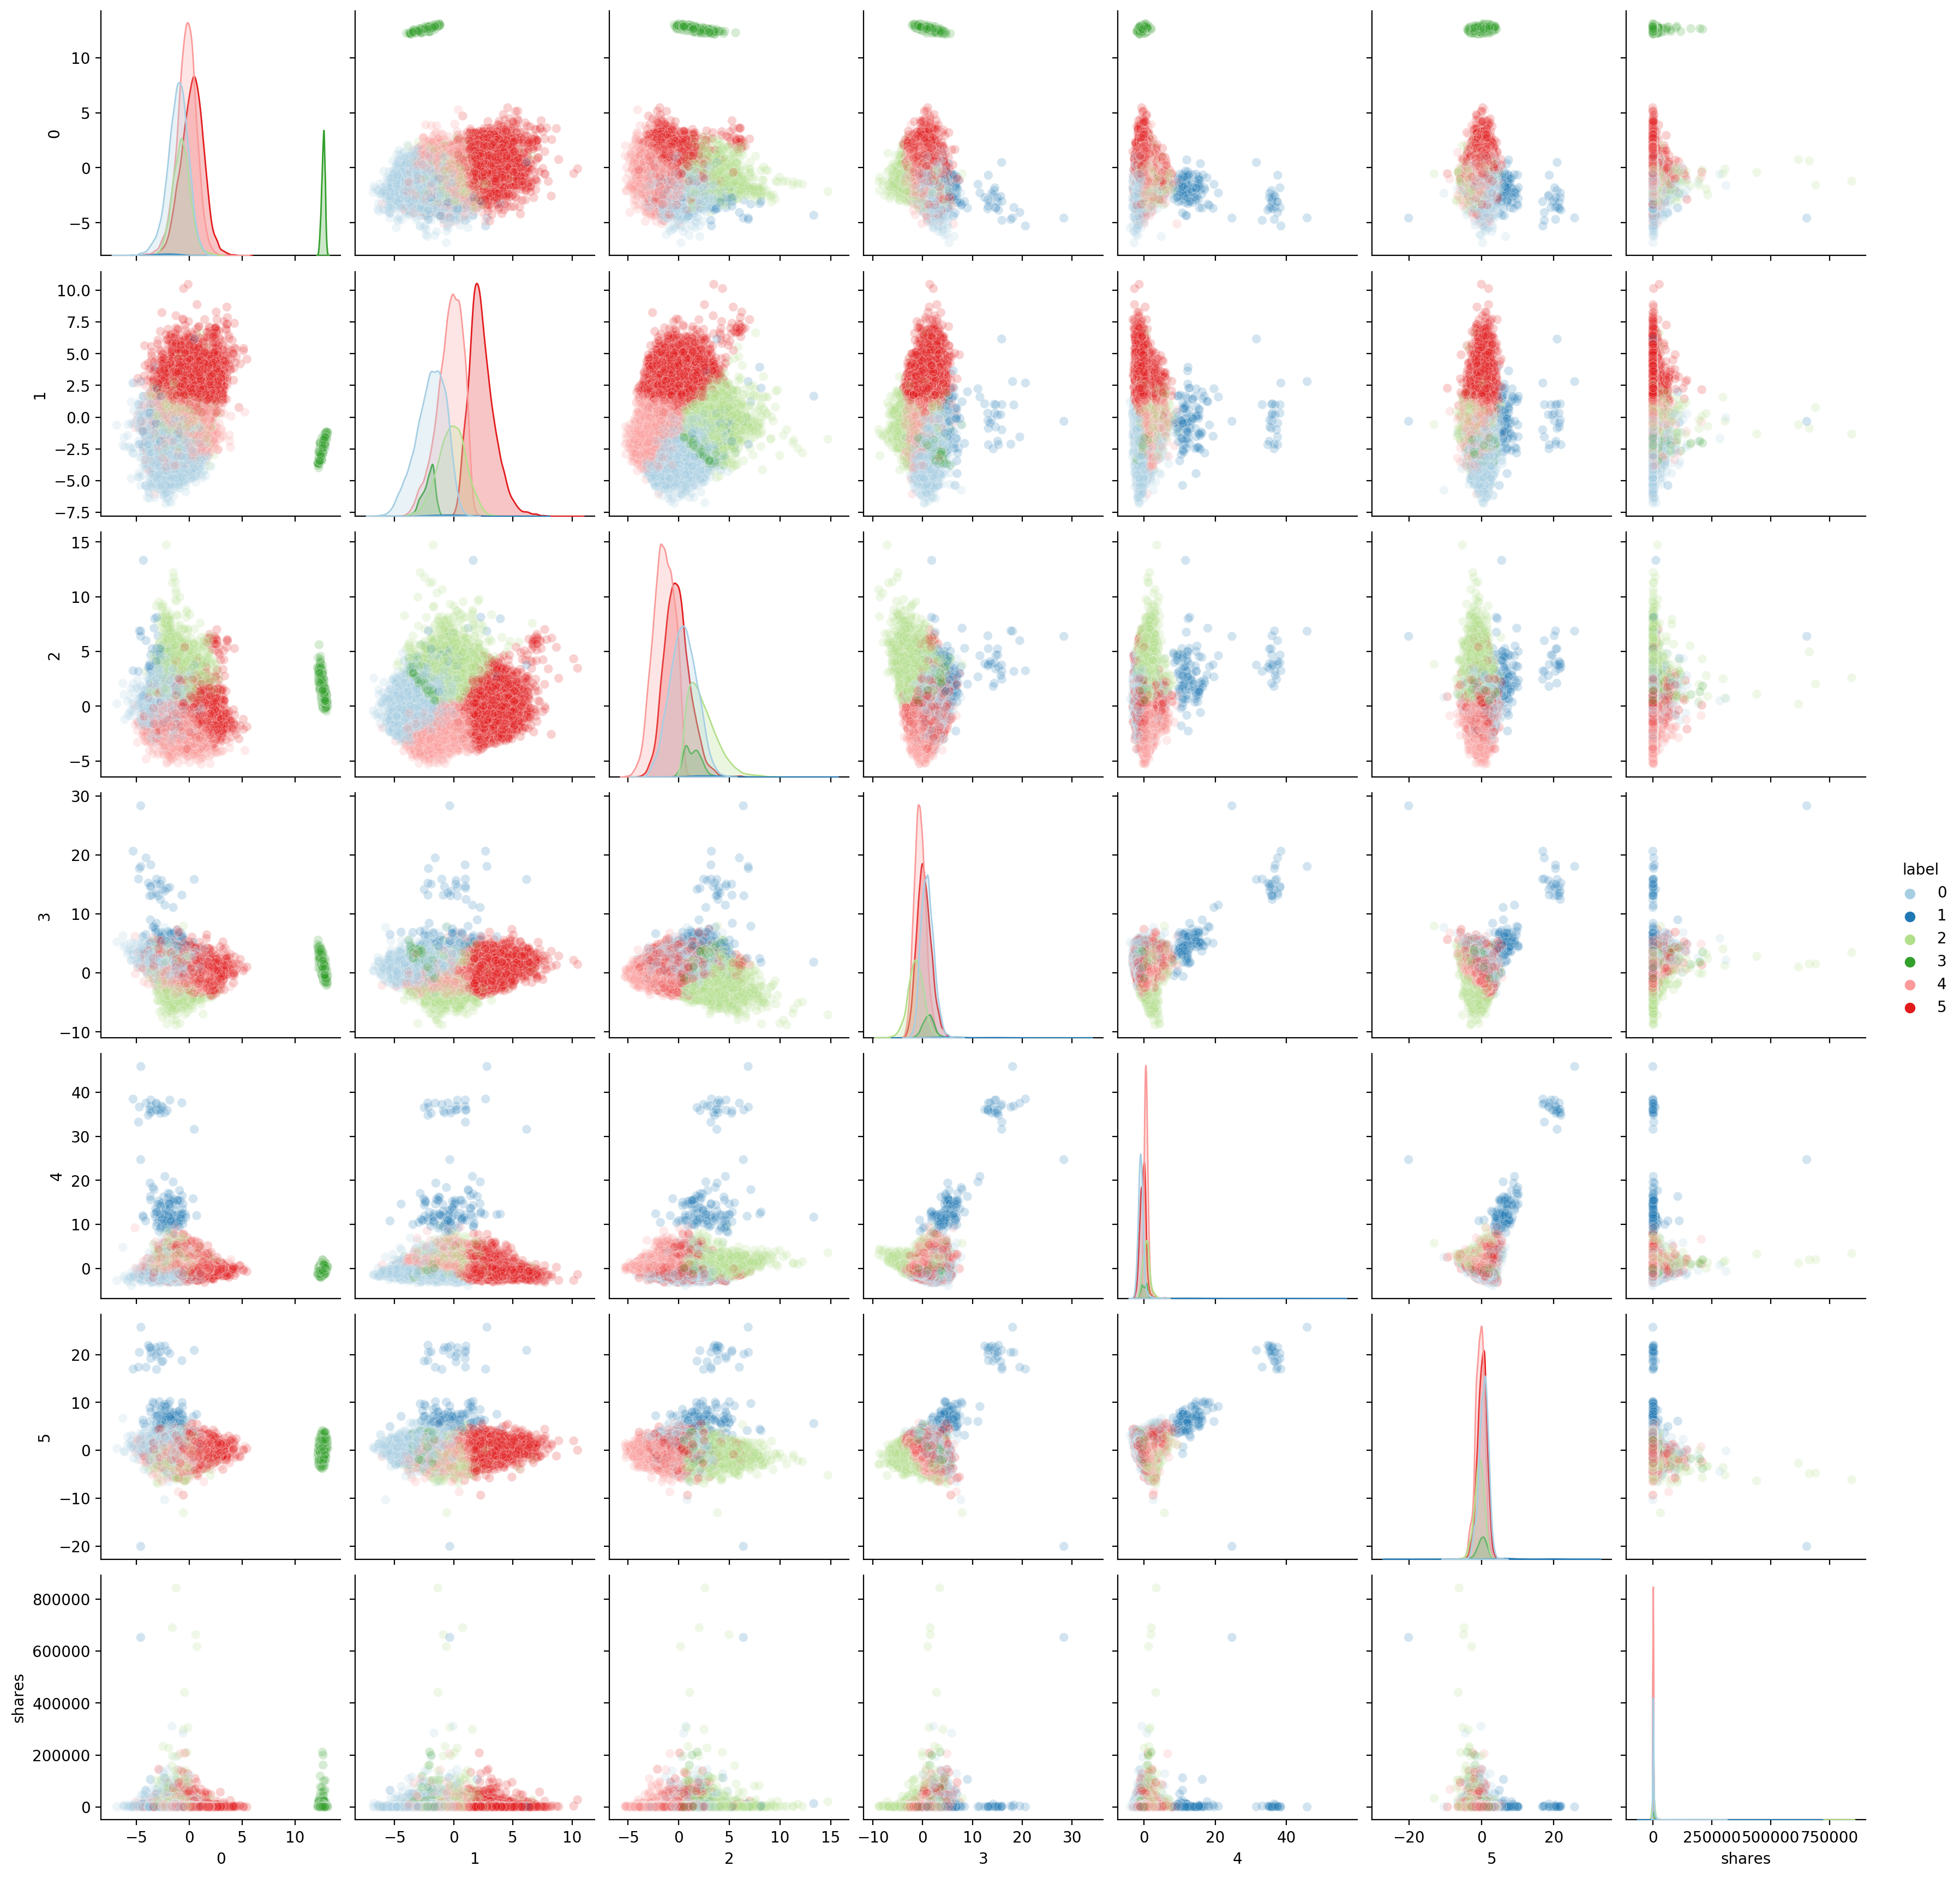

In [14]:
# attach labels to pca components
pca_features['label'] = data_pca.label.values
pca_features['shares'] = data_pca.shares.values

# use thresh to select only the higher varience components
columns_drop = list(features[features.varience < thresh].index)
pca_features = pca_features.drop(columns = columns_drop)

# Plot
sns.pairplot(data=pca_features,hue='label',palette='Paired',plot_kws=dict(alpha=0.2));